In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Veri setinin yolunu belirleyin
veri_seti_yolu = "brain_tumor_dataset"

In [3]:
# Görüntülerin boyutunu belirleyin (inceptionV3 için 299x299)
img_yukseklik, img_genislik = 299, 299
batch_size = 32

In [5]:
# Veri ön işleme ve artırma
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    veri_seti_yolu,
    target_size=(img_yukseklik, img_genislik),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    veri_seti_yolu,
    target_size=(img_yukseklik, img_genislik),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
#inceptionV3 modelini yükleyin keras ile, son katmanı çıkarın,input shape'i belirleyin
# Load the inceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_yukseklik, img_genislik, 3))

In [7]:
# Tüm katmanları dondurun
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Yeni katmanlar ekleyin  
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

In [13]:
# Modeli derleyin
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
#Modeli eğitin
model.fit(train_generator,
          steps_per_epoch = train_generator.samples // batch_size,
          validation_data = validation_generator, 
          validation_steps = validation_generator.samples // batch_size,
          epochs = 10)

Epoch 1/10
6/6 [==============================] - 7s 1s/step - loss: 0.5234 - accuracy: 0.7719 - val_loss: 0.4426 - val_accuracy: 0.8125
Epoch 2/10
6/6 [==============================] - 6s 1s/step - loss: 0.4751 - accuracy: 0.8187 - val_loss: 0.4063 - val_accuracy: 0.8438
Epoch 3/10
6/6 [==============================] - 6s 1s/step - loss: 0.2678 - accuracy: 0.9240 - val_loss: 0.2192 - val_accuracy: 0.9375
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 0.2817 - accuracy: 0.8958 - val_loss: 0.1886 - val_accuracy: 0.9375
Epoch 5/10
6/6 [==============================] - 6s 1s/step - loss: 0.2341 - accuracy: 0.9181 - val_loss: 0.2591 - val_accuracy: 0.8438
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 0.1728 - accuracy: 0.9427 - val_loss: 0.1433 - val_accuracy: 0.9062
Epoch 7/10
6/6 [==============================] - 6s 1s/step - loss: 0.2252 - accuracy: 0.9298 - val_loss: 0.0731 - val_accuracy: 1.0000
Epoch 8/10
6/6 [=========================

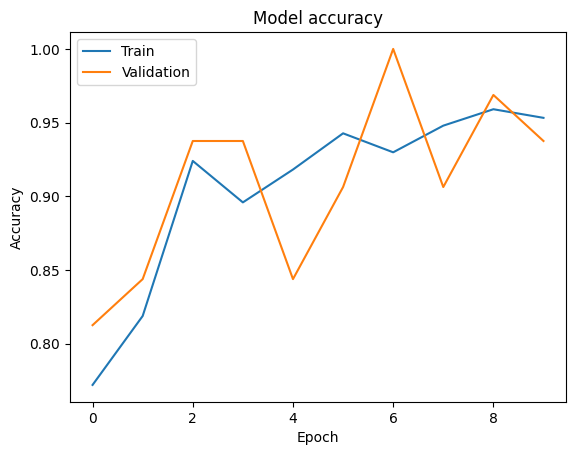

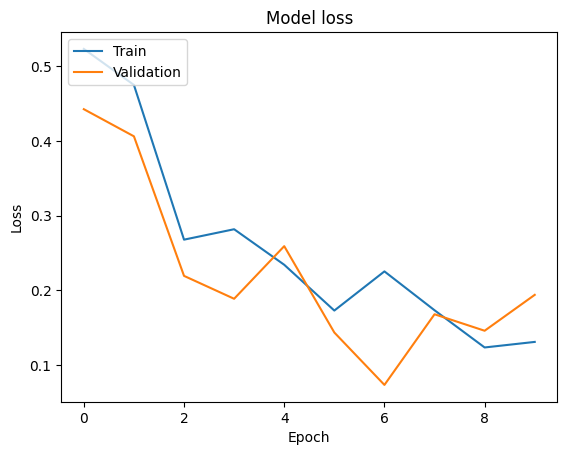

In [17]:
#matplotlib ile eğitim sonuçlarını görselleştirin
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [20]:
# Modeli kaydedin
model.save("inceptionV3_model_3_tumor.h5")
model.save("inceptionV3_model_3_tumor.keras")

/opt/anaconda3/envs/Python-for-AI/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
#tkinter ile tahmin yapma
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy as np
import tensorflow as tf
import keras

# Sınıf etiketlerini tanımlayın
class_labels = ['albatross', 'bald_eagle', 'black_footed_albatross', 'blue_whale', 'brown_pelican', 'california_sea_lion', 'common_dolphin', 'dall_porpoise', 'dusky_dolphin', 'fin_whale', 'gray_whale', 'humpback_whale', 'killer_whale', 'northern_fur_seal', 'northern_right_whale', 'northern_sea_lion', 'northern_sea_otter', 'pacific_white_sided_dolphin', 'sea_otter', 'seal', 'short_finned_pilot_whale', 'sperm_whale', 'stellers_sea_lion']

# Modeli yükle
model = keras.models.load_model('inceptionV3_model_3_tumor.h5')

# Resmi yükle ve ön işleme yap
def load_img():
    global img, image_data
    for img_display in frame.winfo_children():
        img_display.destroy()
    file_path = filedialog.askopenfilename()
    img = Image.open(file_path)
    img = img.resize((img_yukseklik, img_genislik))
    image_data = np.array(img)
    image_data = np.expand_dims(image_data, axis=0)
    image_data = image_data / 255.0
    img = ImageTk.PhotoImage(img)
    panel = Label(frame, image=img)
    panel.image = img
    panel.pack()

# Tahmin yap
def classify():
    global image_data
    pred = model.predict(image_data)
    pred_class = class_labels[np.argmax(pred)]
    for pred_display in frame2.winfo_children():
        pred_display.destroy()
    pred_label = Label(frame2, text=pred_class)
    pred_label.pack()

# GUI
root = tk.Tk()
root.title('Eagle Eye')
root.resizable(False, False)
root.geometry('800x600')
root.configure(bg='gray')

# Arayüz
frame = Frame(root, width=600, height=400)
frame.pack(pady=20)

frame2 = Frame(root, width=600, height=50)
frame2.pack()

btn = Button(root, text='Select Image', command=load_img, bg='deep sky blue')
btn.pack()

btn2 = Button(root, text='Classify Image', command=classify, bg='light sea green')
btn2.pack()

root.mainloop()



OSError: No file or directory found at inceptionV3_model_3_tumor.h5

In [4]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy as np
from tensorflow import keras

# Sınıf etiketlerini tanımlayın
class_labels = ['no', 'yes']

# Modeli yükle
model = keras.models.load_model('inceptionV3_model_3_tumor.h5')

# Görüntü boyutlarını al
img_yukseklik, img_genislik = model.input_shape[1:3]

# Resmi yükle ve ön işleme yap
def load_img():
    global img, image_data
    for img_display in frame.winfo_children():
        img_display.destroy()
    file_path = filedialog.askopenfilename()
    img = Image.open(file_path)
    img = img.resize((img_genislik, img_yukseklik))
    image_data = np.array(img)
    image_data = np.expand_dims(image_data, axis=0)
    image_data = image_data / 255.0
    img = ImageTk.PhotoImage(img)
    panel = Label(frame, image=img)
    panel.image = img
    panel.pack()

# Tahmin yap ve sonuçları görüntüle
def classify():
    global image_data
    pred = model.predict(image_data)
    top_indices = np.argsort(pred[0])[::-1][:5]  # En yüksek 5 tahmin
    result_text = ""
    for i in top_indices:
        class_label = class_labels[i]
        confidence = pred[0][i] * 100
        result_text += f"{class_label}: {confidence:.2f}%\n"
    result_label.config(text=result_text)

# GUI
root = tk.Tk()
root.title('Eagle Eye')
root.resizable(False, False)
root.geometry('800x600')
root.configure(bg='gray')

# Arayüz
frame = Frame(root, width=600, height=400)
frame.pack(pady=20)

result_frame = Frame(root, width=600, height=200)
result_frame.pack()

btn = Button(root, text='Select Image', command=load_img, bg='deep sky blue')
btn.pack()

btn2 = Button(root, text='Classify Image', command=classify, bg='light sea green')
btn2.pack()

result_label = Label(result_frame, text="", justify=LEFT, font=("Arial", 14))
result_label.pack(side=LEFT)

root.mainloop()

1/1 [==============================] - 0s 56ms/step


: 